© [Mariia Seleznova](https://www.ai.math.uni-muenchen.de/members/postdocs/mariia-seleznova/index.html), 2025. [CC BY 4.0](https://creativecommons.org/licenses/by/4.0/).

# ➗ Support Vector Machines (SVM)

In this notebook, we introduce **Support Vector Machines** — a powerful class of models that choose decision boundaries by maximizing the margin between classes. We'll begin by exploring why this principle matters, and how it compares to other linear classifiers.

## 🧭 Introduction: How to Choose a Decision Boundary?

Suppose we are given a **linearly separable** dataset for binary classification. That is, there exists a hyperplane that perfectly separates the two classes. In this case, there are infinitely many such hyperplanes — so **which one should we choose**?

This is not a trivial question — different learning algorithms answer it in different ways.

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg/1920px-Svm_separating_hyperplanes_%28SVG).svg.png" alt="svm" width="400"/>
  <br/>
  <a href="https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:Svm_separating_hyperplanes_(SVG).svg">Source: Wikipedia</a>
</div>


In previous classes, we saw how different models **implicitly or explicitly prefer** different solutions:

- **Least squares classification** (`LinearBinaryClassification`) finds the solution that minimizes squared error — unique under linear independence of features.
- **Ridge classification** (`RidgeClassifier`) adds L2 regularization, favoring hyperplanes with smaller norms.
- **Logistic regression** finds a boundary that balances the log-likelihood of the two classes — typically closer to the densest overlap region.

While all of these models can achieve perfect classification on separable data, their **decision boundaries can differ significantly**. Before we formulate the SVM model, let’s first revisit the decision boundaries produced by these models from previous classes.


In [7]:
# Enable autoreloading of imported modules
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# Add the repo root (two levels up from this notebook) to sys.path
sys.path.insert(0, os.path.abspath("../../"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading from local `iris_data_set.csv`...


/var/folders/9v/zb2h9_ys5yz0c88dl39lnxbh0000gn/T/ipykernel_35192/2168764849.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['iris type'].replace(



Least squares classification accuracy: 100.00
Ridge classification accuracy: 100.00
Logistic regression accuracy: 100.00


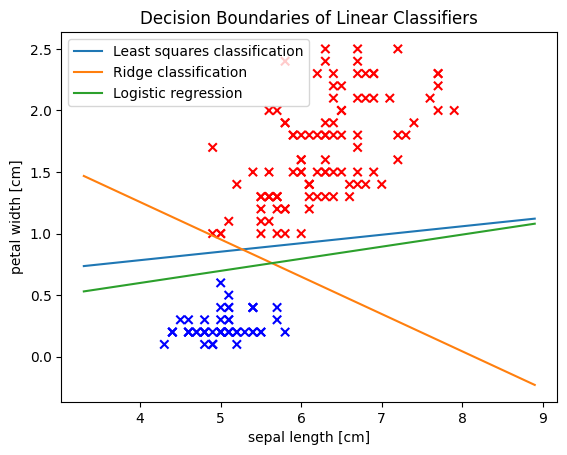

In [8]:
# === Imports ===
from courselib.utils.loaders import load_irises
from courselib.models.linear_models import LinearBinaryClassification, RidgeClassifier
from courselib.models.glm import LogisticRegression
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy


# === Load and preprocess data ===
df = load_irises()

# Binary classification: setosa vs. non-setosa
df['class'] = df['iris type'].replace(
    ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'],
    [-1, 1, 1]
)

# Select two features for 2D visualization
X = df[['sepal length [cm]', 'petal width [cm]']].to_numpy()
Y = df['class'].to_numpy()

# === Model setup ===
w_init = [0] * X.shape[1]
b_init = 0
optimizer = GDOptimizer(learning_rate=1e-2)

# Instantiate and train models
models = {
    "Least squares classification": LinearBinaryClassification(w_init, b_init, optimizer),
    "Ridge classification": RidgeClassifier(w_init, b_init, optimizer),
    "Logistic regression": LogisticRegression(w_init, b_init, optimizer)
}

# Train models
for name, model in models.items():
    Y_train = np.where(Y == -1, 0, 1) if name == "Logistic regression" else Y
    model.fit(X, Y_train, num_epochs=10000, batch_size=len(X))

# === Evaluate ===
print()
for name, model in models.items():
    labels = [0, 1] if name == "Logistic regression" else [-1, 1]
    Y_train = np.where(Y == -1, 0, 1) if name == "Logistic regression" else Y
    acc = binary_accuracy(model.decision_function(X), Y_train, class_labels=labels)
    print(f"{name} accuracy: {acc:.2f}")

# === Plot data and decision boundaries ===
fig, ax = plt.subplots()
colors = df['class'].replace([-1, 1], ['blue', 'red'])
ax.scatter(X[:, 0], X[:, 1], marker='x', color=colors)

# Plotting setup
x1 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)

for name, model in models.items():
    w1, w2 = model.w
    b = model.b
    x2 = -b / w2 - (w1 / w2) * x1
    ax.plot(x1, x2, label=name)

ax.set_xlabel('sepal length [cm]')
ax.set_ylabel('petal width [cm]')
ax.legend()
plt.title("Decision Boundaries of Linear Classifiers")
plt.show()


## 🧠 Support Vector Machines (SVM)

**Support Vector Machines (SVMs)** choose a separating hyperplane explicitly using the **maximum margin** principle — they select a hyperplane with the greatest distance to the closest data points from both classes.


### 📐 Distance to a Hyperplane

Let the hyperplane in $\mathbb{R}^d$ be defined as:

$$
H = \{x \in \mathbb{R}^d \mid \langle w, x \rangle + b = 0\}, \quad w \in \mathbb{R}^d, \, b \in \mathbb{R}
$$

Then, the distance from a point $x$ to $H$ is:

$$
\text{dist}(x, H) = \frac{|\langle w, x \rangle + b|}{\|w\|_2}
$$

### 📏 Margin of a Hyperplane

Given a dataset $\{(x_i, y_i)\}_{i=1}^N$, the margin of a hyperplane is defined as:

$$
M(w, b) = \min_i \frac{|\langle w, x_i \rangle + b|}{\|w\|_2}
$$

The max-margin classifier seeks to solve:

$$
\underset{w, b}{\operatorname{argmax}} \ \frac{1}{\|w\|_2} \min_i |\langle w, x_i \rangle + b| \quad \text{subject to} \quad y_i(\langle w, x_i \rangle + b) \geq 0
$$

However, this formulation is **scale-invariant**:

$$
\forall \alpha \neq 0, \quad M(\alpha w, \alpha b) = M(w, b)
$$

So, to make the solution unique, we fix the scale such that:

$$
\min_i |\langle w, x_i \rangle + b| = 1
$$

This leads to the **normalized hard-margin SVM** problem:

## 🗿 Hard-Margin SVM

$$
\underset{w, b}{\operatorname{argmin}} \ \|w\|_2^2 \quad \text{subject to} \quad y_i(\langle w, x_i \rangle + b) \geq 1 \quad \forall i
$$

This assumes perfect linear separability and allows **no margin violations**.

<div align="center">
  <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/1920px-SVM_margin.png" alt="svm" width="400"/>
  <br/>
  <a href="https://en.wikipedia.org/wiki/Support-vector_machine#/media/File:SVM_margin.png">Source: Wikipedia</a>
</div>


### ⚙️ How Is Hard-Margin SVM Solved?

This is a classic **quadratic programming (QP)** problem, which can be solved by:

- Generic QP solvers (e.g., CVXOPT)
- Specialized algorithms like **SMO (Sequential Minimal Optimization)**, which solves the **dual problem** (covered next week)
- Libraries like **LIBSVM** (used in scikit-learn)

> ❗ QP solvers work with the entire dataset matrix $X$ and do not scale well to large datasets.


### 🧷 What Are Support Vectors?

Support vectors are the points **on the margin**, satisfying:

$$
y_i(\langle w, x_i \rangle + b) = 1
$$

Only these points determine the final solution; the others have no influence on the SVM optimal hyperplane.


## 🧘 Soft-Margin SVM

When the data is **not linearly separable**, the hard-margin SVM has **no feasible solution**. To fix this, we introduce **slack variables** $\xi_i \geq 0$ to allow margin violations:

$$
\underset{w, b, \xi}{\operatorname{argmin}} \ \|w\|_2^2 + C \sum_{i=1}^N \xi_i \quad \text{subject to} \quad y_i(\langle w, x_i \rangle + b) \geq 1 - \xi_i, \quad \xi_i \geq 0 \quad \forall i
$$

Here, $C > 0$ is a **hyperparameter** that balances **margin maximization** (low $\|w\|^2$) and **error minimization** (low $\sum \xi_i$):

- Large $C$: penalizes violations heavily (closer to hard-margin)
- Small $C$: allows more margin violations in favor of wider margin


### 🔁 Reformulation as Unconstrained Problem

We observe that the optimal $\xi_i$ will always satisfy:

$$
\xi_i = \max(0, 1 - y_i(\langle w, x_i \rangle + b))
$$

Plugging this into the objective gives the unconstrained problem:

$$
\underset{w, b}{\operatorname{argmin}} \ \|w\|_2^2 + C \sum_{i=1}^N \max(0, 1 - y_i(\langle w, x_i \rangle + b))
$$

This is equivalent to a **GLM with hinge loss** and **Ridge regularization** (with coefficient $1/C$):


### 📌 Hinge Loss

The hinge loss is defined as:

$$
\mathcal{L}(y, y') = \max(0, 1 - y y')
$$

So the final form becomes:

$$
\underset{w, b}{\operatorname{argmin}} \ \sum_{i=1}^N \mathcal{L}(h(x_i), y_i) +\dfrac{1}{C}\|w\|_2^2 , \quad \text{where} \quad h(x_i)=\langle w, x_i \rangle + b
$$

This problem can be solved using **gradient-based methods** (e.g. subgradient descent), just like other GLMs.

## ⚙️ Implementation of Soft-Margin SVM

The hinge loss $\mathcal{L}(y, y') = \max(0, 1 - y y')$ is piecewise linear, and at the "kink" (when $1 - y y' = 0 $), it doesn't have a true derivative. Analogous to the approach we took when differentiating Lasso penalty term, we use one of the **subgradients** of the loss instead:

$$
\frac{\partial \mathcal{L}}{\partial y'} =
\begin{cases}
    -y, & \text{if } 1 - y y' > 0 \\
    0,  & \text{otherwise}
\end{cases}
$$


> 💡 **Gradients Computation**
> 
> For the soft-margin SVM loss, the gradients are given by:
> 
> - **With respect to $w$**:
>   $$
>   \nabla_w \mathcal{L}(w, b, X, Y) =
>   2w - C \sum_{i=1}^N \mathbf{1}[1 - y_i h(x_i) > 0] \cdot y_i x_i
>   $$
> 
> - **With respect to $b$**:
>   $$
>   \nabla_b \mathcal{L}(w, b, X, Y) =
>   - C \sum_{i=1}^N \mathbf{1}[1 - y_i h(x_i) > 0] \cdot y_i
>   $$
> where $\mathbf{1}[A]$ is the indicator of condition $A$

These expressions allow us to implement a **gradient descent loop** for training soft-margin SVM using the same framework as for GLMs. We will now implement a linear SVM model as a subclass of `TrainableModel` base class.


In [9]:
from courselib.models.base import TrainableModel

class LinearSVM(TrainableModel):

    def __init__(self, w, b, optimizer, C=10.):
        super().__init__(optimizer)
        self.w = np.array(w, dtype=float)
        self.b = np.array(b, dtype=float)
        self.C = C
    
    def loss_grad(self, X, y):
       # Compute raw model output
        output = self.decision_function(X)

        # Identify margin violations: where 1 - y*h(x) > 0
        mask = (1 - y * output) > 0
        y_masked = y[mask]
        X_masked = X[mask]

        # Compute gradients
        grad_w = 2 * self.w - self.C * np.mean(y_masked[:, None] * X_masked, axis=0)
        grad_b = - self.C * np.mean(y_masked) if len(y_masked) > 0 else 0.0

        return {"w": grad_w, "b": grad_b}
    
    def decision_function(self, X):
        return X @ self.w + self.b
    
    def _get_params(self):
        return {"w": self.w, "b": self.b}

    def __call__(self, X):
        return np.where(self.decision_function(X) >= 0, 1, -1)

### 📈 Training SVM and Plotting the Decision Boundary

We now train our linear SVM on a 2D projection of the Iris dataset and visualize the resulting separating hyperplane.

For this experiment, we choose a regularization parameter of $C = 10$. Since the dataset is **linearly separable**, a large $C$ encourages the model to find a **hard-margin solution** by penalizing any violations heavily.

However, large $C$ values also make optimization **less stable**. Moreover, the training procedure using **subgradient descent**:

- Can get stuck in **flat regions** of the hinge loss (where gradients vanish) instead of converging to global minima
- Is sensitive to hyperparameters like the learning rate
- Converges slowly compared to smooth losses (e.g., logistic)

> ⚠️ **Note:** Solving SVMs using gradient descent is not the typical approach in practice — most libraries use **Quadratic Programming solvers** or **SMO**. But GD-based training remains a useful learning exercise and allows comparison with other GLMs under a unified framework.

In [10]:
from courselib.optimizers import GDOptimizer
from courselib.utils.metrics import binary_accuracy

w = [0]*X.shape[1]
b = 0
optimizer = GDOptimizer(learning_rate=1e-3)

metrics_dict = {"accuracy": lambda y_pred, y_true: binary_accuracy(y_pred, y_true), 
                "loss": lambda y_pred, y_true: np.mean(np.maximum(0, 1 - y_true * y_pred))}

svm = LinearSVM(w, b, optimizer, C=10.)
metrics_history = svm.fit(X,Y, num_epochs = 20000, batch_size=len(X), compute_metrics=True, metrics_dict=metrics_dict)

The final train accuracy: 100.0%


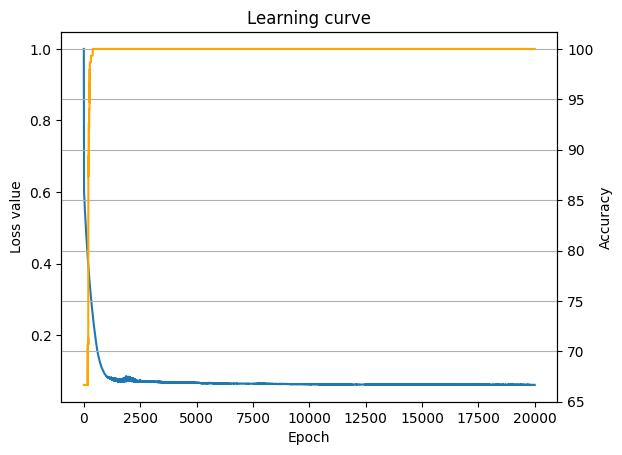

In [11]:
fig, ax = plt.subplots()

ax.plot(range(len(metrics_history['loss'])), metrics_history['loss'])
ax.set_ylabel('Loss value')

ax2 = ax.twinx()
ax2.plot(range(len(metrics_history['accuracy'])), metrics_history['accuracy'], color='orange')
ax2.set_ylabel('Accuracy')

ax.set_xlabel('Epoch')

plt.title('Learning curve')
plt.grid()

print(f'The final train accuracy: {round(metrics_history['accuracy'][-1],2)}%')

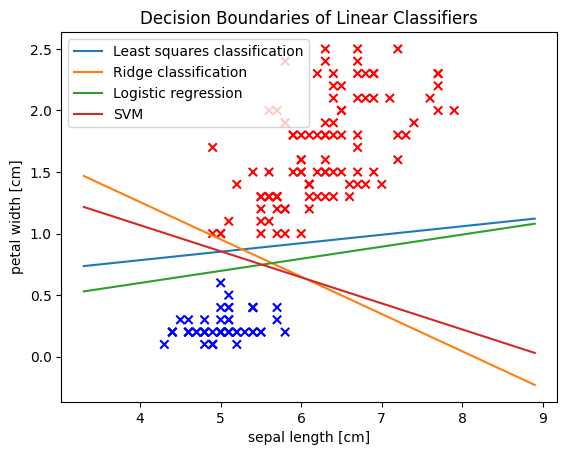

In [12]:
models['SVM'] = svm

# === Plot data and decision boundaries ===
fig, ax = plt.subplots()
colors = df['class'].replace([-1, 1], ['blue', 'red'])
ax.scatter(X[:, 0], X[:, 1], marker='x', color=colors)

# Plotting setup
x1 = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)

for name, model in models.items():
    w1, w2 = model.w
    b = model.b
    x2 = -b / w2 - (w1 / w2) * x1
    ax.plot(x1, x2, label=name)

ax.set_xlabel('sepal length [cm]')
ax.set_ylabel('petal width [cm]')
ax.legend()
plt.title("Decision Boundaries of Linear Classifiers")
plt.show()


## 🧪 Exercise: Tracking the Margin During SVM Training

If the training proceeds correctly (i.e. the optimizer does not get stuck or diverge), the minimum value of $y_i h(x_i)$ — called the **functional margin** — should increase during training, and ideally converge to 1 for a linearly separable problem. This corresponds to a zero-loss solution.

Implement a function to compute the minimum margin over all training points:
$$
M = \min_i \, y_i h(x_i)
$$
and track this value during training by adding it to `metrics_dict`. Plot how the margin changes during training.

Try to tune the hyperparameters (learning rate, $C$, number of training epochs) so that the margin over time approaches **1**, which corresponds to the SVM’s max-margin condition.